In [1]:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
# oof_fc

In [2]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

from artgor_utils import *

In [3]:
file_folder = '../data'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')

In [4]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [5]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [6]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [7]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [8]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [9]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 408.70 Mb (54.0% reduction)
Mem. usage decreased to 195.94 Mb (48.8% reduction)


In [10]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_median'] = df.groupby('molecule_name')['dist'].transform('median')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    
    
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['type_0_couples_count'] = df.groupby(['molecule_name', 'type_0'])['id'].transform('count')
    df['type_1_couples_count'] = df.groupby(['molecule_name', 'type_1'])['id'].transform('count')
    
    df['molecule_distx_mean'] = df.groupby('molecule_name')['dist_x'].transform('mean')
    df['molecule_distx_median'] = df.groupby('molecule_name')['dist_x'].transform('median')
    df['molecule_distx_min'] = df.groupby('molecule_name')['dist_x'].transform('min')
    df['molecule_distx_max'] = df.groupby('molecule_name')['dist_x'].transform('max')
    df['molecule_distx_std'] = df.groupby('molecule_name')['dist_x'].transform('std')
    
    
    
    df['molecule_disty_mean'] = df.groupby('molecule_name')['dist_y'].transform('mean')
    df['molecule_disty_median'] = df.groupby('molecule_name')['dist_y'].transform('median')
    df['molecule_disty_min'] = df.groupby('molecule_name')['dist_y'].transform('min')
    df['molecule_disty_max'] = df.groupby('molecule_name')['dist_y'].transform('max')
    df['molecule_disty_std'] = df.groupby('molecule_name')['dist_y'].transform('std')
   
   
    
    
    df['molecule_distz_mean'] = df.groupby('molecule_name')['dist_z'].transform('mean')
    df['molecule_distz_median'] = df.groupby('molecule_name')['dist_z'].transform('median')
    df['molecule_distz_min'] = df.groupby('molecule_name')['dist_z'].transform('min')
    df['molecule_distz_max'] = df.groupby('molecule_name')['dist_z'].transform('max')
    df['molecule_distz_std'] = df.groupby('molecule_name')['dist_z'].transform('std')
    
   
    
    
    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min', 'skew', 'median']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_sum'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] + df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_mult'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] * df[num_col]


    df = reduce_mem_usage(df)
    return df

In [11]:
train = create_features_full(train)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 14064.57 Mb (-36.0% reduction)


In [12]:
test = create_features_full(test)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 7535.15 Mb (-36.2% reduction)


In [13]:
# train.to_csv('../cache/train2.csv', index=False)
# test.to_csv('../cache/test2.csv', index=False)

In [14]:
# train = pd.read_csv('../cache/train2.csv')
# test = pd.read_csv('../cache/test2.csv')

In [15]:
for f in ['atom_index_0', 'atom_index_1', 'atom_1', 'type_0', 'type', 'atom_0', 'type_1']:
#     if f in good_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [16]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [17]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']

In [18]:
# for f in ['atom_0', 'type_1']:
# #     if f in good_columns:
#     lbl = LabelEncoder()
#     lbl.fit(list(X[f].values) + list(X_test[f].values))
#     X[f] = lbl.transform(list(X[f].values))
#     X_test[f] = lbl.transform(list(X_test[f].values))

In [19]:
# X = train[good_columns].copy()
# y = train['scalar_coupling_constant']
# X_test = test[good_columns].copy()

In [20]:
# X = train.copy()
# y = train['scalar_coupling_constant']
# del train

# X_test = test.copy()
# del test
# del structures

In [21]:
# X = X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)

# X_test = X_test.drop(['id', 'molecule_name'], axis=1)

In [22]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
y_fc = train['fc']
X_test = test[good_columns].copy()

In [23]:
del train, test

In [24]:
import gc
gc.collect()

528

In [25]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [26]:
# params = {'num_leaves': 128,
#           'min_child_samples': 79,
#           'objective': 'regression',
#           'max_depth': 9,
#           'learning_rate': 0.2,
#           "boosting_type": "gbdt",
#           "subsample_freq": 1,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'mae',
#           "verbosity": -1,
#           'reg_alpha': 0.1,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 1.0
#          }
# result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000)

Fold 1 started at Sun Jun  9 08:39:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.12447	valid_1's l1: 1.16845
[1000]	training's l1: 0.993481	valid_1's l1: 1.06722
[1500]	training's l1: 0.916564	valid_1's l1: 1.01727
[2000]	training's l1: 0.858369	valid_1's l1: 0.982344
[2500]	training's l1: 0.810786	valid_1's l1: 0.955918
[3000]	training's l1: 0.771538	valid_1's l1: 0.935778
[3500]	training's l1: 0.737627	valid_1's l1: 0.919462
[4000]	training's l1: 0.707621	valid_1's l1: 0.905736
[4500]	training's l1: 0.681027	valid_1's l1: 0.894366
[5000]	training's l1: 0.657065	valid_1's l1: 0.885036
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.657065	valid_1's l1: 0.885036
Fold 2 started at Sun Jun  9 08:56:08 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.124	valid_1's l1: 1.16819
[1000]	training's l1: 0.995327	valid_1's l1: 1.07055
[1500]	training's l1: 0.917726	valid_1's l1: 1.01

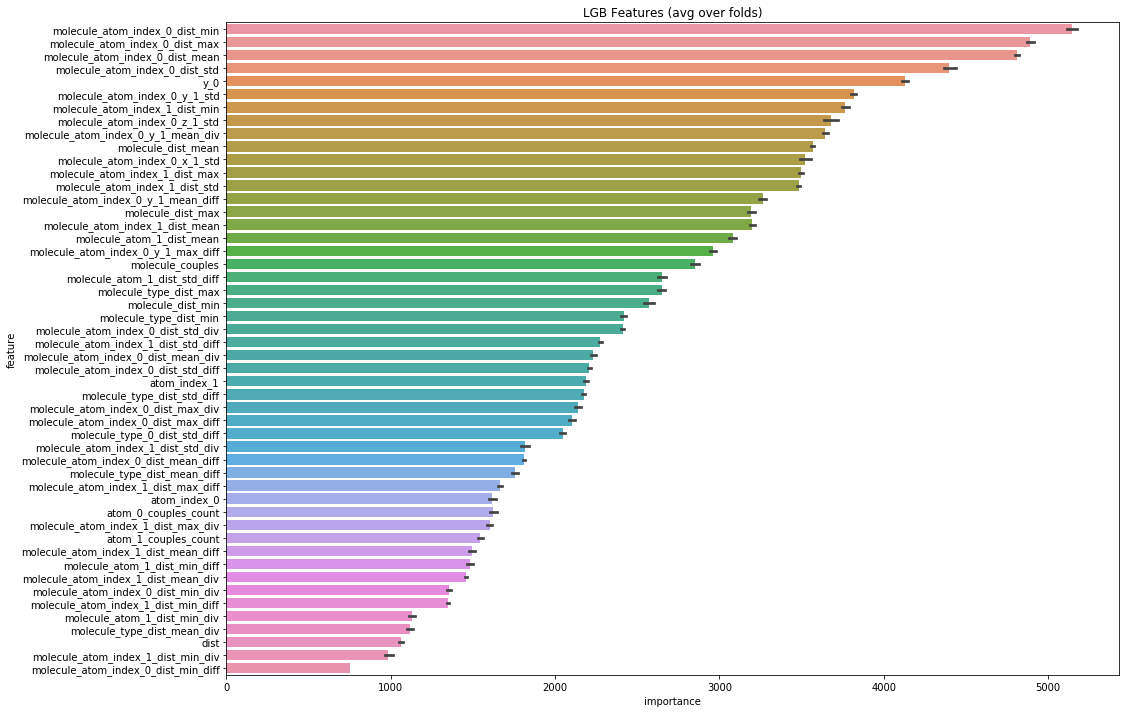

In [27]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y_fc, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [28]:
X['oof_fc'] = result_dict_lgb['oof']
X_test['oof_fc'] = result_dict_lgb['prediction']

Fold 1 started at Sun Jun  9 10:06:01 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.808331	valid_1's l1: 0.843459
[1000]	training's l1: 0.764774	valid_1's l1: 0.827962
[1500]	training's l1: 0.730977	valid_1's l1: 0.818045
[2000]	training's l1: 0.701581	valid_1's l1: 0.809731
[2500]	training's l1: 0.675372	valid_1's l1: 0.802762
[3000]	training's l1: 0.651264	valid_1's l1: 0.796024
[3500]	training's l1: 0.629036	valid_1's l1: 0.790106
[4000]	training's l1: 0.608736	valid_1's l1: 0.785025
[4500]	training's l1: 0.589441	valid_1's l1: 0.780099
[5000]	training's l1: 0.571032	valid_1's l1: 0.775321
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.571032	valid_1's l1: 0.775321
Fold 2 started at Sun Jun  9 10:23:44 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.809209	valid_1's l1: 0.846121
[1000]	training's l1: 0.764684	valid_1's l1: 0.82952
[1500]	training's l1: 0.730599	valid_1's 

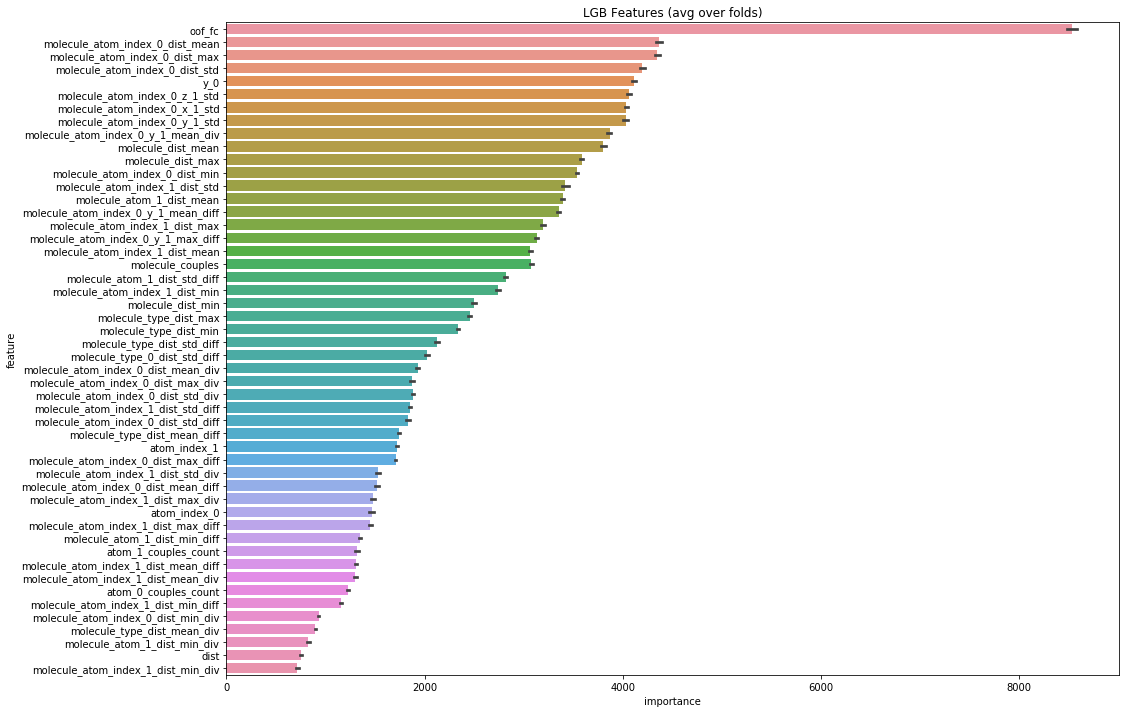

In [29]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [33]:
sub['scalar_coupling_constant'] = result_dict_lgb2['prediction']
sub.to_csv('../submissions/sub4.csv', index=False)
sub.head()

id  scalar_coupling_constant
0  4658147         9.242146752836028
1  4658148       200.131600273047610
2  4658149         6.676326170530450
3  4658150       197.619030889657182
4  4658151         5.346614196571115

In [34]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub4.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:44<00:00, 1.49MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 892 ms, sys: 328 ms, total: 1.22 s
Wall time: 47.2 s


In [36]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub4.csv   2019-06-09 06:05:24  None         complete  -0.603       None          
sub4.csv   2019-06-09 06:03:59  None         complete  -0.196       None          
sub3.csv   2019-06-09 00:57:08  None         complete  -0.376       None          
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2.csv   2019-06-08 13:03:54  None         complete  -0.400       None          
sub1.csv   2019-06-04 16:51:51  None         complete  0.299        None          


In [37]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('../submissions/sub4a.csv', index=False)
sub.head()

Training of type 0
Fold 1 started at Sun Jun  9 12:47:58 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.39027	valid_1's l1: 1.60213
[1000]	training's l1: 1.18827	valid_1's l1: 1.57653
[1500]	training's l1: 1.0251	valid_1's l1: 1.55532
[2000]	training's l1: 0.889684	valid_1's l1: 1.53555
[2500]	training's l1: 0.778138	valid_1's l1: 1.52085
[3000]	training's l1: 0.685816	valid_1's l1: 1.50965
[3500]	training's l1: 0.607114	valid_1's l1: 1.50046
[4000]	training's l1: 0.540822	valid_1's l1: 1.49308
[4500]	training's l1: 0.4828	valid_1's l1: 1.48695
[5000]	training's l1: 0.432795	valid_1's l1: 1.48221
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.432795	valid_1's l1: 1.48221
Fold 2 started at Sun Jun  9 12:51:31 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.38081	valid_1's l1: 1.60077
[1000]	training's l1: 1.177	valid_1's l1: 1.57505
[1500]	training's l1: 1.01338	valid_1's l1: 

Fold 2 started at Sun Jun  9 13:19:32 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.356818	valid_1's l1: 0.843801
[1000]	training's l1: 0.174644	valid_1's l1: 0.817671
[1500]	training's l1: 0.091534	valid_1's l1: 0.809491
[2000]	training's l1: 0.0501154	valid_1's l1: 0.80661
[2500]	training's l1: 0.0278739	valid_1's l1: 0.804926
[3000]	training's l1: 0.0154919	valid_1's l1: 0.804316
[3500]	training's l1: 0.00864867	valid_1's l1: 0.804043
[4000]	training's l1: 0.00516486	valid_1's l1: 0.803882
[4500]	training's l1: 0.00352798	valid_1's l1: 0.80382
[5000]	training's l1: 0.00274192	valid_1's l1: 0.803786
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00274192	valid_1's l1: 0.803786
Fold 3 started at Sun Jun  9 13:20:11 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.362389	valid_1's l1: 0.830467
[1000]	training's l1: 0.17673	valid_1's l1: 0.802385
[1500]	training's l1: 0.093020

[4500]	training's l1: 0.263041	valid_1's l1: 0.623223
[5000]	training's l1: 0.241373	valid_1's l1: 0.619459
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.241373	valid_1's l1: 0.619459
Fold 3 started at Sun Jun  9 13:39:33 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.640914	valid_1's l1: 0.721449
[1000]	training's l1: 0.552426	valid_1's l1: 0.692545
[1500]	training's l1: 0.484674	valid_1's l1: 0.672767
[2000]	training's l1: 0.430325	valid_1's l1: 0.65817
[2500]	training's l1: 0.385133	valid_1's l1: 0.646912
[3000]	training's l1: 0.34701	valid_1's l1: 0.638404
[3500]	training's l1: 0.314576	valid_1's l1: 0.631632
[4000]	training's l1: 0.287022	valid_1's l1: 0.626548
[4500]	training's l1: 0.262384	valid_1's l1: 0.622384
[5000]	training's l1: 0.240743	valid_1's l1: 0.618537
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.240743	valid_1's l1: 0.618537
Fold 4 started at Sun Jun  9 13:45:06 2019
Tr

[3500]	training's l1: 0.385252	valid_1's l1: 0.651045
[4000]	training's l1: 0.357106	valid_1's l1: 0.64535
[4500]	training's l1: 0.332194	valid_1's l1: 0.640749
[5000]	training's l1: 0.309579	valid_1's l1: 0.636741
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.309579	valid_1's l1: 0.636741
Fold 4 started at Sun Jun  9 14:34:09 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.668456	valid_1's l1: 0.729985
[1000]	training's l1: 0.597467	valid_1's l1: 0.7064
[1500]	training's l1: 0.540959	valid_1's l1: 0.689881
[2000]	training's l1: 0.492935	valid_1's l1: 0.677377
[2500]	training's l1: 0.45222	valid_1's l1: 0.667543
[3000]	training's l1: 0.416694	valid_1's l1: 0.659277
[3500]	training's l1: 0.385061	valid_1's l1: 0.652453
[4000]	training's l1: 0.35699	valid_1's l1: 0.64685
[4500]	training's l1: 0.3321	valid_1's l1: 0.641774
[5000]	training's l1: 0.309572	valid_1's l1: 0.637457
Did not meet early stopping. Best iteration i

id  scalar_coupling_constant
0  4658147        10.612632640040115
1  4658148       190.155238400975605
2  4658149         6.264580723843387
3  4658150       186.176984974592102
4  4658151         4.955438506535664

In [38]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub4a.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:39<00:00, 1.69MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 864 ms, sys: 315 ms, total: 1.18 s
Wall time: 41.9 s


In [40]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub4a.csv  2019-06-09 09:26:24  None         complete  -0.830       None          
sub4.csv   2019-06-09 06:05:24  None         complete  -0.603       None          
sub4.csv   2019-06-09 06:03:59  None         complete  -0.196       None          
sub3.csv   2019-06-09 00:57:08  None         complete  -0.376       None          
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2.csv   2019-06-08 13:03:54  None         complete  -0.400       None          
sub1.csv   2019-06-04 16:51:51  None         complete  0.299        None          


In [41]:
scalar_coupling_contributions.head()

molecule_name  atom_index_0  atom_index_1  type                  fc  \
0  dsgdb9nsd_000001             1             0  1JHC  83.022400000000005   
1  dsgdb9nsd_000001             1             2  2JHH -11.034700000000001   
2  dsgdb9nsd_000001             1             3  2JHH -11.032500000000001   
3  dsgdb9nsd_000001             1             4  2JHH -11.031900000000000   
4  dsgdb9nsd_000001             2             0  1JHC  83.022199999999998   

         sd      pso       dso  
0  0.254579  1.25862  0.272010  
1  0.352978  2.85839 -3.433600  
2  0.352944  2.85852 -3.433870  
3  0.352934  2.85855 -3.433930  
4  0.254585  1.25861  0.272013